In [1]:
import pandas as pd
import networkx as nx
import itertools

In [2]:

file_path = 'Liguori_translations_FR_normalized_publishers_translators_places.xlsx'
df = pd.read_excel(file_path)

In [3]:
import math

In [4]:

G_1876_1900 = nx.MultiDiGraph()

# Function to extract and sort years chronologically
# For this period we had to tweak the function so that in cases of subsequent editions entered as
# e.g., 1868-1892 it extracts in this case all years between 1876 and 1915
def extract_years(row, cutoff_year0, cutoff_year1):
    year = row['First ed.']
    subsequent = row['Subsq. ed.']
    
    all_years = []
    
    # Check and add 'First ed.' year if within the interval
    if not math.isnan(year) and cutoff_year0 < int(year) <= cutoff_year1:
        all_years.append(int(year))
    
    # Process 'Subsq. ed.' column
    if isinstance(subsequent, str):
        subsequent_years = []
        for entry in subsequent.split(','):
            entry = entry.strip()
            if '-' in entry:  # Detect ranges like '1868-1892'
                try:
                    start, end = map(int, entry.split('-'))
                    # Add years within the range that fit the cutoff
                    subsequent_years.extend(
                        year for year in range(start, end + 1)
                        if cutoff_year0 < year <= cutoff_year1
                    )
                except ValueError:
                    # Handle malformed ranges gracefully
                    continue
            else:  # Single year entry
                try:
                    year = int(entry.split()[0])  # Extract year from single entry
                    if cutoff_year0 < year <= cutoff_year1:
                        subsequent_years.append(year)
                except ValueError:
                    continue
        
        all_years.extend(subsequent_years)
    
    # Sort the final list of years
    all_years = sorted(all_years)
    
    return all_years



def is_valid_year(x):
    try:
        year_int = int(x)
        return 1875 < year_int and year_int <= 1915
    except ValueError:
        return False
    

filtered_df = df[df['First ed.'].apply(lambda x: x if not (math.isnan(x) or not is_valid_year(x)) else None).notna()]

unique_publishers = set()

for publishers in filtered_df['Normalized Publisher']:
    if isinstance(publishers, str):
        unique_publishers.update([publisher.strip() for publisher in publishers.split(';')])
    else:
        unique_publishers.update([publishers])

for publisher in unique_publishers:
    G_1876_1900.add_node(publisher, publications=[])
    

for index, row in filtered_df.iterrows():
    title = row['Title']
    years = extract_years(row, 1875, 1915)
    editions = sum(1 for year in years) if years != [] else 0  # Calculate number of editions based on years after 1875 through to 1900 (including exceptions that span the early 20th century)
    publishers = [publisher.strip() for publisher in row['Normalized Publisher'].split('; ')] if isinstance(row['Normalized Publisher'], str) else [row['Normalized Publisher']]
    translator = row['Normalized Translator']
    places = [place.strip() for place in row['Publ. place'].split('; ')] if isinstance(row['Publ. place'], str) else [str(row['Publ. place']).strip()]

    for publisher in unique_publishers:
        if publisher in publishers:
            G_1876_1900.nodes[publisher]['publications'].append({
                'title': title,
                'years': years,
                'editions': [editions],
                'publisher': publishers,
                'translator': translator,
                'place': places
            })


for publisher in G_1876_1900.nodes():
    if 'publications' in G_1876_1900.nodes[publisher]:  # Check if 'publications' key exists
        magnitude = sum(pub['editions'][0] for pub in G_1876_1900.nodes[publisher]['publications'])
        G_1876_1900.nodes[publisher]['magnitude'] = magnitude

In [11]:
len(G_1850_75.nodes) # 1850-75

62

In [5]:
len(G_1876_1900.nodes)

43

In [7]:

nodes_with_sizes = [(publisher, data['magnitude']) for publisher, data in G_1876_1900.nodes(data=True) if 'magnitude' in data]

sorted_nodes = sorted(nodes_with_sizes, key=lambda x: x[1], reverse=True)

for publisher, size in sorted_nodes:
    print(f"Publisher: {publisher}, Size: {size}")

Publisher: casterman, Size: 30
Publisher: desclee, Size: 12
Publisher: saintaugustin, Size: 9
Publisher: gaume, Size: 8
Publisher: ardant, Size: 7
Publisher: de brouwer, Size: 7
Publisher: librairie internationale catholique, Size: 6
Publisher: zech, Size: 6
Publisher: jean evang, Size: 5
Publisher: nan, Size: 5
Publisher: barbou, Size: 4
Publisher: pouy, Size: 4
Publisher: kittler, Size: 3
Publisher: lethielleux, Size: 3
Publisher: pontificaux, Size: 3
Publisher: mame, Size: 3
Publisher: rittler, Size: 3
Publisher: lefebvre, Size: 3
Publisher: briguet, Size: 3
Publisher: librairie de loeuvre de saintpaul, Size: 3
Publisher: bourguetcalas, Size: 2
Publisher: delhomme, Size: 2
Publisher: maison des pères rédemptoristes, Size: 2
Publisher: saintpaul, Size: 2
Publisher: vivs, Size: 1
Publisher: mersch, Size: 1
Publisher: cattier, Size: 1
Publisher: leday, Size: 1
Publisher: prunet, Size: 1
Publisher: decallonneliagre, Size: 1
Publisher: demers, Size: 1
Publisher: lecoffre, Size: 1
Publish

In [6]:

def add_edge_with_attributes(G, publisher_A, publisher_B, title, source_years, target_years,
                             source_translator, target_translator, source_num_editions,
                             target_num_editions, source_place, target_place, weight, relation, key):
    G.add_edge(publisher_A, publisher_B, title=title, source_years=source_years, target_years=target_years,
               source_translator=source_translator, target_translator=target_translator,
               source_num_editions=source_num_editions, target_num_editions=target_num_editions,
               source_place=source_place, target_place=target_place, weight=weight, relation=relation, key=key)

In [7]:
existing_edges = set()

# Function to add edges between publishers with support for multiple edges of the same type
def add_edges_between_publishers(G):
    for pub_A, pub_B in itertools.combinations(G.nodes, 2):  # Iterate over pairs of nodes
        publications_A = G.nodes[pub_A]['publications']
        publications_B = G.nodes[pub_B]['publications']
        
        # Compare all publications between two publishers
        for publication_A in publications_A:
            for publication_B in publications_B:
                title_A, title_B = publication_A['title'], publication_B['title']
                years_A, years_B = publication_A['years'], publication_B['years']
                editions_A, editions_B = publication_A['editions'], publication_B['editions']
                translators_A, translators_B = publication_A['translator'], publication_B['translator']
                publishers_A, publishers_B = set(publication_A['publisher']), set(publication_B['publisher'])
                
                # Ensure translators_A and translators_B are lists
                translators_A = translators_A if isinstance(translators_A, list) else []
                translators_B = translators_B if isinstance(translators_B, list) else []

                
                # Initialize edge counters
                edge_counter = 0

                # Check for copublication
                if (len(publishers_A) == 1 & len(publishers_B) == 1) and title_A == title_B and set(years_A) == set(years_B):
                    # Create a unique edge key
                    edge_counter = sum(1 for key in existing_edges if f"copub_{pub_A}_{pub_B}_" in key) + 1
                    edge_key = f"copub_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                    # Check if the edge already exists
                    if edge_key not in existing_edges:
                        weight = max(editions_A[0], editions_B[0])
                        add_edge_with_attributes(
                            G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                            editions_A, editions_B, publication_A['place'], publication_B['place'],
                            weight, 'copublication', edge_key
                        )
                        existing_edges.add(edge_key)

                # Check for reprint relation
                if set(translators_A) == set(translators_B) and title_A == title_B and years_A and years_B:
                    if len(years_A) > 0 and len(years_B) > 0:
                        if years_A[0] < years_B[0] and publishers_A != publishers_B:
                            edge_counter += 1
                            edge_key = f"reprint_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                            # Check if the edge already exists
                            if edge_key not in existing_edges:
                                weight = editions_B[0]
                                add_edge_with_attributes(
                                    G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                                    editions_A, editions_B, publication_A['place'], publication_B['place'],
                                    weight, 'reprint', edge_key
                                )
                                existing_edges.add(edge_key)

                # Check for retranslation relation
                if set(translators_A) != set(translators_B) and title_A == title_B and years_A and years_B:
                    if len(years_A) > 0 and len(years_B) > 0:
                        if years_A[0] < years_B[0] and publishers_A != publishers_B:
                            edge_counter += 1
                            edge_key = f"retrans_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                            # Check if the edge already exists
                            if edge_key not in existing_edges:
                                weight = editions_B[0]
                                add_edge_with_attributes(
                                    G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                                    editions_A, editions_B, publication_A['place'], publication_B['place'],
                                    weight, 'retranslation', edge_key
                                )
                                existing_edges.add(edge_key)

In [8]:

add_edges_between_publishers(G_1876_1900)

In [11]:
len(G_1839_50.edges)

272

In [16]:
len(G_1850_75.edges)

276

In [9]:
len(G_1876_1900.edges)

55

In [52]:
len(existing_edges) # G_thru_1825

471

In [16]:
len(existing_edges) # G_1826_38

550

In [12]:
len(existing_edges) # G_1839_50

272

In [17]:
len(existing_edges) # G_1850_75

276

In [29]:
len(existing_edges) # G_1876_1900

103

In [15]:

for title, first_ed, subsq_ed, edition, publisher, translator, place in zip(
        filtered_df['Title'],
        filtered_df['First ed.'],
        filtered_df['Subsq. ed.'],
        filtered_df['Editions'],
        filtered_df['Normalized Publisher'],
        filtered_df['Normalized Translator'],
        filtered_df['Publ. place']
    ):
    
    publisher_list = [pub.strip() for pub in str(publisher).split(';') if pub.strip()]
    
    translator_list = [trans.strip() for trans in str(translator).split(';') if trans.strip()]
    
    place_list = [pl.strip() for pl in str(place).split(';') if pl.strip()]
    
    if len(publisher_list) > 1:
        
        for pub_A, pub_B in itertools.combinations(publisher_list, 2):
            # Assign a weight based on editions
            weight = max(edition, edition)
            # Generate a unique edge key for each copublication instance
            edge_counter = sum(1 for key in existing_edges if f"copub_{pub_A}_{pub_B}_" in key) + 1
            edge_key = f"copub_{pub_A}_{pub_B}_{title}_{edge_counter}"

            # Check if the edge already exists
            if edge_key not in existing_edges:
                add_edge_with_attributes(
                    G_1876_1900, pub_A, pub_B, title, [first_ed, subsq_ed], [first_ed, subsq_ed], translator_list, translator_list,
                    [edition], [edition], place_list, place_list, weight, 'copublication', edge_key
                )
                existing_edges.add(edge_key)


In [16]:

out_degrees = dict(G_1876_1900.out_degree())
in_degrees = dict(G_1876_1900.in_degree())
overall_degrees = {node: out_degrees.get(node, 0) + in_degrees.get(node, 0) for node in G_1876_1900.nodes()}

nodes_by_out_degree = sorted(out_degrees, key=out_degrees.get, reverse=True)
nodes_by_in_degree = sorted(in_degrees, key=in_degrees.get, reverse=True)
nodes_by_overall_degree = sorted(overall_degrees, key=overall_degrees.get, reverse=True)

print("Nodes ordered by outgoing degree:")
for node in nodes_by_out_degree:
    print(node, out_degrees[node])

print("\nNodes ordered by incoming degree:")
for node in nodes_by_in_degree:
    print(node, in_degrees[node])

print("\nNodes ordered by overall degree:")
for node in nodes_by_overall_degree:
    print(node, overall_degrees[node])

Nodes ordered by outgoing degree:
jean evang 18
casterman 15
desclee 15
barbou 10
saintaugustin 9
cattier 5
gaume 5
librairie internationale catholique 4
lecoffre 4
delhomme 3
leday 2
bray 2
lefebvre 2
descleee 2
mame 2
lefevbre 1
lethielleux 1
librairie de loeuvre de saintpaul 1
pouy 1
de brouwer 1
mersch 0
prunet 0
ardant 0
maison des pères rédemptoristes 0
vivs 0
poussielgue 0
demers 0
nan 0
kittler 0
briguet 0
douniol 0
le chevallier 0
decallonneliagre 0
tablissements de brepols 0
bellet 0
saintpaul 0
beauchesne 0
rittler 0
aux bureaux de la sainte famille 0
bourguetcalas 0
pontificaux 0
zech 0
maitre 0

Nodes ordered by incoming degree:
desclee 12
lefebvre 11
de brouwer 11
zech 10
maitre 10
mame 7
kittler 5
librairie internationale catholique 4
briguet 4
saintaugustin 3
gaume 3
le chevallier 3
leday 2
cattier 2
lefevbre 2
tablissements de brepols 2
librairie de loeuvre de saintpaul 2
rittler 2
barbou 1
casterman 1
nan 1
descleee 1
lecoffre 1
saintpaul 1
aux bureaux de la sainte fa

In [17]:


weights = []

outgoing_weighted_degrees = {}
incoming_weighted_degrees = {}
overall_weighted_degrees = {}

for node in G_1876_1900.nodes():
    successors = []
    for node_id in G_1876_1900.successors(node):
        successors.append(node_id)
    weights = []
    for u, v, key, attr in G_1876_1900.edges(keys=True, data=True):
        if (u in successors and v == node) or (u == node and v in successors):
            weight = attr['weight']
            #weights.append(sum(weight))
            weights.append(weight)
    #outgoing_weight = sum(sum(G11.edges[node, neighbor]['weight']) for neighbor in G11.successors(node))
    outgoing_weighted_degrees[node] = sum(weights)

for node in G_1876_1900.nodes():
    predecessors = []
    for node_id in G_1876_1900.predecessors(node):
        predecessors.append(node_id)
    weights = []
    for u, v, key, attr in G_1876_1900.edges(keys=True, data=True):
        if (u in predecessors and v == node) or (u == node and v in predecessors):
            weight = attr['weight']
            # weights.append(sum(weight))
            weights.append(weight)
    #incoming_weight = sum(sum(G11.edges[neighbor, node]['weight']) for neighbor in G11.predecessors(node))
    incoming_weighted_degrees[node] = sum(weights)

for node in G_1876_1900.nodes():
    overall_weighted_degree = outgoing_weighted_degrees.get(node, 0) + incoming_weighted_degrees.get(node, 0)
    overall_weighted_degrees[node] = overall_weighted_degree

sorted_outgoing_weighted_degrees = dict(sorted(outgoing_weighted_degrees.items(), key=lambda item: item[1], reverse=True))
sorted_incoming_weighted_degrees = dict(sorted(incoming_weighted_degrees.items(), key=lambda item: item[1], reverse=True))
sorted_overall_weighted_degrees = dict(sorted(overall_weighted_degrees.items(), key=lambda item: item[1], reverse=True))

print("Outgoing Weighted Degrees:", sorted_outgoing_weighted_degrees)
print("Incoming Weighted Degrees:", sorted_incoming_weighted_degrees)
print("Overall Weighted Degrees:", sorted_overall_weighted_degrees)

Outgoing Weighted Degrees: {'casterman': 239, 'librairie internationale catholique': 115, 'desclee': 23, 'jean evang': 18, 'saintaugustin': 15, 'barbou': 10, 'cattier': 5, 'gaume': 5, 'de brouwer': 5, 'lecoffre': 4, 'delhomme': 3, 'leday': 2, 'bray': 2, 'lefebvre': 2, 'descleee': 2, 'mame': 2, 'lefevbre': 1, 'lethielleux': 1, 'librairie de loeuvre de saintpaul': 1, 'pouy': 1, 'mersch': 0, 'prunet': 0, 'ardant': 0, 'maison des pères rédemptoristes': 0, 'vivs': 0, 'poussielgue': 0, 'demers': 0, nan: 0, 'kittler': 0, 'briguet': 0, 'douniol': 0, 'le chevallier': 0, 'decallonneliagre': 0, 'tablissements de brepols': 0, 'bellet': 0, 'saintpaul': 0, 'beauchesne': 0, 'rittler': 0, 'aux bureaux de la sainte famille': 0, 'bourguetcalas': 0, 'pontificaux': 0, 'zech': 0, 'maitre': 0}
Incoming Weighted Degrees: {'rittler': 210, 'librairie internationale catholique': 115, 'kittler': 19, 'desclee': 17, 'saintaugustin': 14, 'de brouwer': 13, 'lefebvre': 11, 'zech': 10, 'maitre': 10, 'mame': 7, 'brigue

In [18]:

from collections import Counter


source_place_counter = Counter()
target_place_counter = Counter()
overall_place_counter = Counter()


for publisher_A, publisher_B, data in G_1876_1900.edges(data=True):
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    
    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]
    
    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            #place_list = [place_list]
            target_places[i] = [place_list]
            
    for place_list in source_places:
        for place in place_list:
            source_place_counter[place] += 1
            
    for place_list in target_places:
        for place in place_list:
            target_place_counter[place] += 1
    
    for place_list in source_places + target_places:
        #if isinstance(place_list, str):
            #place_list = [place_list]  # Convert string to list
        for place in place_list:
            overall_place_counter[place] += 1


sorted_source_places = source_place_counter.most_common()
sorted_target_places = target_place_counter.most_common()
sorted_overall_places = overall_place_counter.most_common()


print("Sorted Source Places:", sorted_source_places)
print("Sorted Target Places:", sorted_target_places)
print("Sorted Overall Places:", sorted_overall_places)

Sorted Source Places: [('Tournai', 46), ('Paris', 29), ('Bruges', 11), ('Limoges', 10), ('Leipzig', 9), ('Tours', 5), ('Lille', 4), ('nan', 3), ('Lyon et Paris', 2), ('unknown', 2), ('Bruxelles', 1), ('de Brouwer', 1), ('Fontainebleau', 1)]
Sorted Target Places: [('Tournai', 35), ('Paris', 30), ('Leipzig', 11), ('Bruges', 10), ('Braine-le-Comte', 10), ('Dijon', 10), ('Lille', 4), ('Nancy', 3), ('nan', 3), ('Turnhout', 2), ('Tours', 2), ('Lyon et Paris', 2), ('Limoges', 1), ('unknown', 1), ('Bruxelles', 1), ('de Brouwer', 1), ('Fribourg', 1), ('Antony (Seine)', 1)]
Sorted Overall Places: [('Tournai', 81), ('Paris', 59), ('Bruges', 21), ('Leipzig', 20), ('Limoges', 11), ('Braine-le-Comte', 10), ('Dijon', 10), ('Lille', 8), ('Tours', 7), ('nan', 6), ('Lyon et Paris', 4), ('Nancy', 3), ('unknown', 3), ('Turnhout', 2), ('Bruxelles', 2), ('de Brouwer', 2), ('Fribourg', 1), ('Fontainebleau', 1), ('Antony (Seine)', 1)]


In [19]:

source_place_counter_weighted = Counter()
target_place_counter_weighted = Counter()
overall_place_counter_weighted = Counter()

for publisher_A, publisher_B, data in G_1876_1900.edges(data=True):
    # Get the weight of the current edge
    weight = data['weight']
    
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]

    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            target_places[i] = [place_list]

    for place_list in source_places:
        for place in place_list:
            # source_place_counter_weighted[place] += weight[0]
            source_place_counter_weighted[place] += weight
            
    for place_list in target_places:
        for place in place_list:
            # target_place_counter_weighted[place] += weight[0]
            target_place_counter_weighted[place] += weight

    for place_list in source_places + target_places:
        for place in place_list:
            # overall_place_counter_weighted[place] += weight[0]
            overall_place_counter_weighted[place] += weight

sorted_source_places_weighted = source_place_counter_weighted.most_common()
sorted_target_places_weighted = target_place_counter_weighted.most_common()
sorted_overall_places_weighted = overall_place_counter_weighted.most_common()

print("Sorted Source Places (Weighted):", sorted_source_places_weighted)
print("Sorted Target Places (Weighted):", sorted_target_places_weighted)
print("Sorted Overall Places (Weighted):", sorted_overall_places_weighted)

Sorted Source Places (Weighted): [('Tournai', 381), ('Paris', 364), ('Leipzig', 342), ('Bruges', 14), ('Limoges', 10), ('Lille', 7), ('Tours', 5), ('de Brouwer', 4), ('nan', 3), ('Lyon et Paris', 2), ('unknown', 2), ('Bruxelles', 2), ('Fontainebleau', 1)]
Sorted Target Places (Weighted): [('Tournai', 370), ('Paris', 365), ('Leipzig', 344), ('Bruges', 13), ('Braine-le-Comte', 10), ('Dijon', 10), ('Lille', 7), ('de Brouwer', 4), ('Nancy', 3), ('nan', 3), ('Turnhout', 2), ('Tours', 2), ('Lyon et Paris', 2), ('Bruxelles', 2), ('Limoges', 1), ('unknown', 1), ('Fribourg', 1), ('Antony (Seine)', 1)]
Sorted Overall Places (Weighted): [('Tournai', 751), ('Paris', 729), ('Leipzig', 686), ('Bruges', 27), ('Lille', 14), ('Limoges', 11), ('Braine-le-Comte', 10), ('Dijon', 10), ('de Brouwer', 8), ('Tours', 7), ('nan', 6), ('Lyon et Paris', 4), ('Bruxelles', 4), ('Nancy', 3), ('unknown', 3), ('Turnhout', 2), ('Fribourg', 1), ('Fontainebleau', 1), ('Antony (Seine)', 1)]


In [20]:

# Initialize counters for unweighted and weighted titles
unweighted_title_counter = Counter()
weighted_title_counter = Counter()

# Initialize dictionaries to store concatenated source and target places for each title
title_source_places = {}
title_target_places = {}

# Iterate over edges in the graph
for publisher_A, publisher_B, data in G_1876_1900.edges(data=True):
    title = data['title']
    weight = data['weight']
    
    # Increment the unweighted and weighted title counters
    unweighted_title_counter[title] += 1
    weighted_title_counter[title] += weight
    
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]

    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            target_places[i] = [place_list]
    
    if title not in title_source_places:
                title_source_places[title] = [] 
            
    for place_list in source_places:
        for place in place_list:
            title_source_places[title].append(place)
    
    if title not in title_target_places:
                title_target_places[title] = [] 
            
    for place_list in target_places:
        for place in place_list:          
            title_target_places[title].append(place)

# Sort titles based on unweighted occurrences
sorted_unweighted_titles = unweighted_title_counter.most_common()

# Sort titles based on weighted occurrences
sorted_weighted_titles = weighted_title_counter.most_common()

for elem in sorted_unweighted_titles:
    print(f"Title and number of connections between places it occasioned: {elem} | Source Places: {set(title_source_places[elem[0]])} | Target Places: {set(title_target_places[elem[0]])}")

for ele in sorted_weighted_titles:
    print(f"Title and weighted number of connections between places it occasioned: {ele} | Source Places: {set(title_source_places[ele[0]])} | Target Places: {set(title_target_places[ele[0]])}")

Title and number of connections between places it occasioned: ('Visite au S. Sacrement et à\xa0 la Sainte Vierge', 49) | Source Places: {'Tours', 'Tournai', 'Limoges', 'Paris'} | Target Places: {'Tournai', 'Dijon', 'Tours', 'Limoges', 'Braine-le-Comte', 'Paris'}
Title and number of connections between places it occasioned: ("Pratique de l'amour envers Jésus-Christ", 6) | Source Places: {'Bruges', 'unknown'} | Target Places: {'Bruges', 'unknown', 'Turnhout'}
Title and number of connections between places it occasioned: ('[Exercice du] Chemin de la Croix, sur le modèle des Chemins de croix Italiens', 6) | Source Places: {'Tournai'} | Target Places: {'Nancy', 'Tournai'}
Title and number of connections between places it occasioned: ('Neuvaine au Sacré-Coeur de Jésus', 5) | Source Places: {'Tournai', 'Paris', 'Leipzig'} | Target Places: {'Tournai', 'Paris', 'Leipzig'}
Title and number of connections between places it occasioned: ('Mater dolorosa. Les douleurs de la Sainte Vierge. Méditation

In [12]:


G_combined = nx.DiGraph()

for u, v, key, attr in G_1876_1900.edges(keys=True, data=True):
    weight = attr.get('weight', 0)  # Default to 0 if 'weight' is missing

    if G_combined.has_edge(u, v):
        G_combined[u][v]['weight'] += weight
    else:
        G_combined.add_edge(u, v, weight=weight)

for node, data in G_1876_1900.nodes(data=True):
    if not G_combined.has_node(node):
        G_combined.add_node(node, **data)

In [22]:

len(G_combined.nodes)

43

In [79]:
len(G_combined.edges) # out of the 471 in G_thru_1825 now collapsed into a digraph:

460

In [24]:
len(G_combined.edges) # out of 550 edges in G_1826_38 

529

In [25]:
len(G_combined.edges) # out of 272 edges in G_1839_50

257

In [27]:
len(G_combined.edges) # out of 276 edges in G_1850_75

252

In [25]:
len(G_combined.edges) # out of 103 edges in G_1876_1900

75

In [30]:

closeness_centralities = nx.closeness_centrality(G_combined)

betweenness_centralities = nx.betweenness_centrality(G_combined)

In [31]:

eigenvector_centralities = nx.eigenvector_centrality(G_combined)

In [85]:
# eigenvector_centralities = nx.eigenvector_centrality(G_combined, max_iter = 500)

In [32]:
import operator

In [33]:

sorted_closeness = sorted(closeness_centralities.items(), key=operator.itemgetter(1), reverse=True)
sorted_betweenness = sorted(betweenness_centralities.items(), key=operator.itemgetter(1), reverse=True)
sorted_eigenvector = sorted(eigenvector_centralities.items(), key=operator.itemgetter(1), reverse=True)

In [34]:
sorted_closeness

[('zech', 0.23669467787114845),
 ('maitre', 0.23669467787114845),
 ('desclee', 0.1523809523809524),
 ('lefebvre', 0.14835164835164835),
 ('mame', 0.14583333333333331),
 ('tablissements de brepols', 0.1134453781512605),
 ('saintaugustin', 0.10158730158730157),
 ('de brouwer', 0.10158730158730157),
 ('gaume', 0.0761904761904762),
 ('kittler', 0.0744047619047619),
 ('le chevallier', 0.07142857142857142),
 ('librairie de loeuvre de saintpaul', 0.06613756613756613),
 ('rittler', 0.06613756613756613),
 ('librairie internationale catholique', 0.06349206349206349),
 ('saintpaul', 0.05714285714285714),
 ('leday', 0.047619047619047616),
 ('cattier', 0.047619047619047616),
 ('lefevbre', 0.047619047619047616),
 ('briguet', 0.047619047619047616),
 (nan, 0.031746031746031744),
 ('lecoffre', 0.031746031746031744),
 ('pontificaux', 0.031746031746031744),
 ('barbou', 0.023809523809523808),
 ('descleee', 0.023809523809523808),
 ('casterman', 0.023809523809523808),
 ('aux bureaux de la sainte famille', 0

In [35]:

sorted_betweenness 

[('desclee', 0.013937282229965157),
 ('casterman', 0.009291521486643438),
 ('librairie internationale catholique', 0.004645760743321719),
 ('saintaugustin', 0.0029036004645760743),
 ('barbou', 0.0029036004645760743),
 ('librairie de loeuvre de saintpaul', 0.0029036004645760743),
 ('tablissements de brepols', 0.0),
 ('de brouwer', 0.0),
 ('jean evang', 0.0),
 ('leday', 0.0),
 ('cattier', 0.0),
 ('gaume', 0.0),
 ('lefebvre', 0.0),
 ('le chevallier', 0.0),
 ('mame', 0.0),
 ('zech', 0.0),
 ('maitre', 0.0),
 ('descleee', 0.0),
 ('lefevbre', 0.0),
 ('rittler', 0.0),
 ('kittler', 0.0),
 ('bray', 0.0),
 ('delhomme', 0.0),
 ('briguet', 0.0),
 (nan, 0.0),
 ('lecoffre', 0.0),
 ('pontificaux', 0.0),
 ('lethielleux', 0.0),
 ('saintpaul', 0.0),
 ('pouy', 0.0),
 ('aux bureaux de la sainte famille', 0.0),
 ('mersch', 0.0),
 ('prunet', 0.0),
 ('ardant', 0.0),
 ('maison des pères rédemptoristes', 0.0),
 ('vivs', 0.0),
 ('poussielgue', 0.0),
 ('demers', 0.0),
 ('douniol', 0.0),
 ('decallonneliagre', 0.0)

In [36]:
sorted_eigenvector

[('saintaugustin', 0.4827008997256514),
 ('tablissements de brepols', 0.4827008997256514),
 ('de brouwer', 0.4827008997256514),
 ('zech', 0.29833432830775347),
 ('maitre', 0.29833432830775347),
 ('desclee', 0.29832565329065025),
 ('lefebvre', 0.18437620753304995),
 ('saintpaul', 1.494074044466134e-06),
 ('mame', 6.163292017227664e-07),
 ('kittler', 2.907141794147431e-07),
 ('librairie de loeuvre de saintpaul', 2.890486294285128e-07),
 ('rittler', 2.890486294285127e-07),
 ('le chevallier', 1.7412568037862212e-07),
 ('gaume', 4.004890648708308e-08),
 ('librairie internationale catholique', 3.838335650085279e-08),
 ('leday', 2.0895081645434654e-08),
 ('cattier', 2.0895081645434654e-08),
 ('lefevbre', 2.0895081645434654e-08),
 (nan, 1.9229531659204354e-08),
 ('lecoffre', 1.9229531659204354e-08),
 ('pontificaux', 1.9229531659204354e-08),
 ('briguet', 3.4068067900165197e-09),
 ('barbou', 1.741256803786221e-09),
 ('descleee', 1.741256803786221e-09),
 ('casterman', 1.741256803786221e-09),
 ('a

In [37]:

weighted_closeness = nx.closeness_centrality(G_combined, distance='weight')
weighted_betweenness = nx.betweenness_centrality(G_combined, weight='weight')
weighted_eigenvector = nx.eigenvector_centrality(G_combined, max_iter = 500, weight='weight')

sorted_weighted_closeness = sorted(weighted_closeness.items(), key=lambda x: x[1], reverse=True)
sorted_weighted_betweenness = sorted(weighted_betweenness.items(), key=lambda x: x[1], reverse=True)
sorted_weighted_eigenvector = sorted(weighted_eigenvector.items(), key=lambda x: x[1], reverse=True)

In [38]:

sorted_weighted_closeness

[('zech', 0.17494824016563146),
 ('maitre', 0.17494824016563146),
 ('mame', 0.12962962962962962),
 ('tablissements de brepols', 0.10714285714285714),
 ('desclee', 0.08963585434173668),
 ('gaume', 0.0761904761904762),
 ('lefebvre', 0.07417582417582418),
 ('le chevallier', 0.07142857142857142),
 ('leday', 0.047619047619047616),
 ('cattier', 0.047619047619047616),
 ('lefevbre', 0.047619047619047616),
 ('saintaugustin', 0.03463203463203463),
 (nan, 0.031746031746031744),
 ('lecoffre', 0.031746031746031744),
 ('barbou', 0.023809523809523808),
 ('descleee', 0.023809523809523808),
 ('casterman', 0.023809523809523808),
 ('briguet', 0.023809523809523808),
 ('aux bureaux de la sainte famille', 0.023809523809523808),
 ('de brouwer', 0.02240896358543417),
 ('kittler', 0.01488095238095238),
 ('pontificaux', 0.013605442176870746),
 ('saintpaul', 0.003556609365737996),
 ('librairie de loeuvre de saintpaul', 0.002532928064842958),
 ('librairie internationale catholique', 0.0016420361247947454),
 ('rit

In [39]:

sorted_weighted_betweenness

[('desclee', 0.013937282229965157),
 ('casterman', 0.009291521486643438),
 ('librairie internationale catholique', 0.004645760743321719),
 ('barbou', 0.003871467286101432),
 ('saintaugustin', 0.0029036004645760743),
 ('librairie de loeuvre de saintpaul', 0.0029036004645760743),
 ('cattier', 0.000967866821525358),
 ('gaume', 0.000967866821525358),
 ('tablissements de brepols', 0.0),
 ('de brouwer', 0.0),
 ('jean evang', 0.0),
 ('leday', 0.0),
 ('lefebvre', 0.0),
 ('le chevallier', 0.0),
 ('mame', 0.0),
 ('zech', 0.0),
 ('maitre', 0.0),
 ('descleee', 0.0),
 ('lefevbre', 0.0),
 ('rittler', 0.0),
 ('kittler', 0.0),
 ('bray', 0.0),
 ('delhomme', 0.0),
 ('briguet', 0.0),
 (nan, 0.0),
 ('lecoffre', 0.0),
 ('pontificaux', 0.0),
 ('lethielleux', 0.0),
 ('saintpaul', 0.0),
 ('pouy', 0.0),
 ('aux bureaux de la sainte famille', 0.0),
 ('mersch', 0.0),
 ('prunet', 0.0),
 ('ardant', 0.0),
 ('maison des pères rédemptoristes', 0.0),
 ('vivs', 0.0),
 ('poussielgue', 0.0),
 ('demers', 0.0),
 ('douniol',

In [40]:
sorted_weighted_eigenvector 

[('de brouwer', 0.7958032709454589),
 ('saintaugustin', 0.44116912002266345),
 ('desclee', 0.32296127593958796),
 ('lefebvre', 0.17731574859522647),
 ('tablissements de brepols', 0.13984556831821202),
 ('zech', 0.09155686226382392),
 ('maitre', 0.09155686226382392),
 ('rittler', 1.0386175804211534e-06),
 ('kittler', 8.90268032963723e-08),
 ('saintpaul', 3.21848131091067e-08),
 ('librairie de loeuvre de saintpaul', 9.891747819132731e-09),
 ('librairie internationale catholique', 2.1153466538343063e-09),
 ('mame', 5.097922593038841e-10),
 ('le chevallier', 1.2507230414671359e-10),
 ('pontificaux', 5.533223259431815e-11),
 ('gaume', 3.923836992838074e-11),
 ('leday', 2.084538402445227e-11),
 ('cattier', 2.084538402445227e-11),
 ('lefevbre', 2.084538402445227e-11),
 (nan, 1.854626078646121e-11),
 ('lecoffre', 1.854626078646121e-11),
 ('briguet', 9.34976783449697e-12),
 ('barbou', 2.452398120523796e-12),
 ('descleee', 2.452398120523796e-12),
 ('casterman', 2.452398120523796e-12),
 ('aux bur

In [10]:
import matplotlib.pyplot as plt
import numpy as np

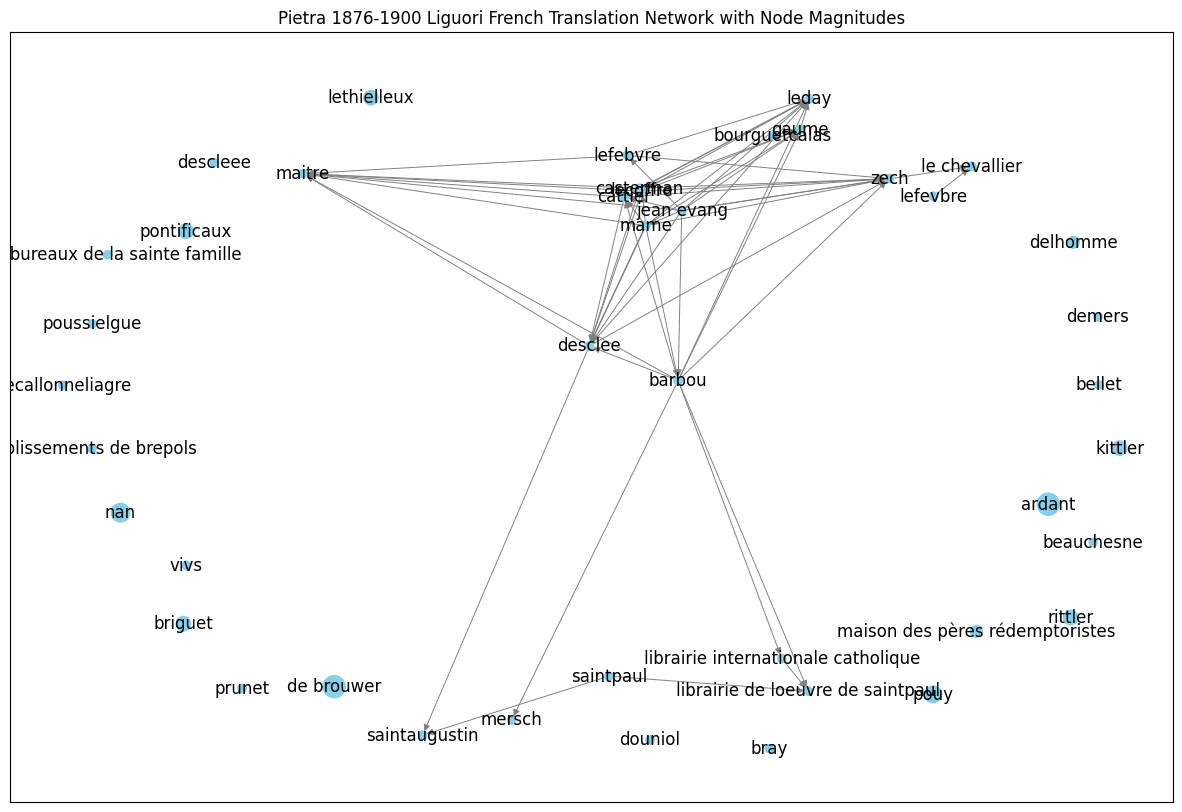

In [13]:

fig, ax = plt.subplots(figsize=(15, 10))

node_sizes = [G_combined.nodes[node].get('magnitude', 1) for node in G_combined.nodes()]

# Scale node sizes for better visualization (adjust scaling factor as needed)
node_sizes = [size * 36 for size in node_sizes]

pos = nx.spring_layout(G_combined)

edge_widths = [np.log(data['weight'] + 1) for _, _, data in G_combined.edges(data=True)]
#edge_widths = [data['weight'] for _, _, data in G_combined.edges(data=True)]

nx.draw_networkx(G_combined, pos, node_size=node_sizes, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths, edge_color='gray', arrows=True)

plt.title("Pietra 1876-1900 Liguori French Translation Network with Node Magnitudes")

plt.savefig('PIETRA_Margento_19th_Cent_Liguori_1876-1900_FR_w_Node_Magnitudes.png')

plt.show()